In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statistics import mean
import statistics
from dateutil.parser import parse

In [3]:
from datetime import datetime

datetime.now()

datetime.datetime(2023, 12, 9, 16, 50, 37, 187308)

In [4]:
nysm_cats_path = "/home/aevans/nwp_bias/src/landtype/data/nysm.csv"

nysm_cats_df = pd.read_csv(nysm_cats_path)
nysm_cats_df

,stid,number,name,lat [degrees],lon [degrees],elevation [m],county,nearest_city,state,distance_from_town [km],direction_from_town [degrees],climate_division,climate_division_name,wfo,commissioned,decommissioned
0,ADDI,107,Addison,42.040360,-77.237260,507.6140,Steuben,Addison,NY,6.9,S,1,Western Plateau,BGM,2016-08-10 18:15:00 UTC,NaN
1,ANDE,111,Andes,42.182270,-74.801390,518.2820,Delaware,Andes,NY,1.5,WSW,2,Eastern Plateau,BGM,2016-08-04 15:55:00 UTC,NaN
2,BATA,24,Batavia,43.019940,-78.135660,276.1200,Genesee,Batavia,NY,4.9,ENE,9,Great Lakes,BUF,2016-02-18 18:40:00 UTC,NaN
3,BEAC,76,Beacon,41.528750,-73.945270,90.1598,Dutchess,Beacon,NY,3.3,NE,5,Hudson Valley,ALY,2016-08-22 16:45:00 UTC,NaN
4,BELD,90,Belden,42.223220,-75.668520,470.3700,Broome,Belden,NY,2.2,NNE,2,Eastern Plateau,BGM,2015-11-30 20:20:00 UTC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,WFMB,14,Whiteface Mountain Base,44.393236,-73.858829,614.5990,Essex,Wilmington,NY,3.5,W,3,Northern Plateau,BTV,2016-01-29 20:55:00 UTC,NaN
122,WGAT,123,Woodgate,43.532408,-75.158597,442.9660,Oneida,Woodgate,NY,1.4,NNW,3,Northern Plateau,BGM,2016-08-29 18:20:00 UTC,NaN
123,WHIT,10,Whitehall,43.485073,-73.423071,36.5638,Washington,Whitehall,NY,8.0,S,7,Champlain Valley,ALY,2015-08-26 20:30:00 UTC,NaN
124,WOLC,79,Wolcott,43.228680,-76.842610,121.2190,Wayne,Wolcott,NY,2.4,WNW,9,Great Lakes,BUF,2016-03-09 18:10:00 UTC,NaN


In [5]:
def load_nysm_data():
    # these parquet files are created by running "get_resampled_nysm_data.ipynb"
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H = []
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)
    nysm_1H_obs = pd.concat(nysm_1H)
    nysm_1H_obs["snow_depth"] = nysm_1H_obs["snow_depth"].fillna(0)
    nysm_1H_obs.dropna(inplace=True)
    return nysm_1H_obs

In [6]:
def read_hrrr_data():
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2018", "2019", "2020", "2021", "2022"]
    savedir = "/home/aevans/ai2es/processed_data/HRRR/ny/"

    # create empty lists to hold dataframes for each model
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        for month in np.arange(1, 13):
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                hrrr_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue

    # concatenate dataframes for each model
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index().dropna()

    # return dataframes for each model
    return hrrr_fcast_and_error_df

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd


def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index

In [8]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.year), (df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(the_list), int(len(the_list) / 5)))
    return the_list

In [9]:
def groupby_month_hrrr(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.time.dt.year), (df.time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, 60, 12))
    return the_list

In [10]:
def anoms_detection_hrrr(df, means, col):
    anoms = []

    for i, _ in enumerate(df["time"]):
        t = df["time"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            if year == str(2018) and month == str(m).zfill(2):
                new_means = means[:12]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2019) and month == str(m).zfill(2):
                new_means = means[12:24]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2020) and month == str(m).zfill(2):
                new_means = means[24:36]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2021) and month == str(m).zfill(2):
                new_means = means[36:48]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2022) and month == str(m).zfill(2):
                new_means = means[48:60]
                anom = tair - new_means[m - 1]
                anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 7))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [11]:
def anoms_detection(df, means, col):
    anoms = []

    for i, _ in enumerate(df["valid_time"]):
        t = df["valid_time"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            new_means = means[:12]
            anom = tair - new_means[m - 1]
            anoms.append(anom)

        # if year == str(2018) and month == str(m).zfill(2):
        #     new_means = means[:12]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2019) and month == str(m).zfill(2):
        #     new_means = means[12:24]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2020) and month == str(m).zfill(2):
        #     new_means = means[24:36]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2021) and month == str(m).zfill(2):
        #     new_means = means[36:48]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2022) and month == str(m).zfill(2):
        #     new_means = means[48:60]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [12]:
# directory = sorted(os.listdir("/home/aevans/nwp_bias/src/correlation/data/indexes"))

# # years = ['2018', '2019', '2020', '2021', '2022']
# years = np.arange(2018, 2023)
# for d in directory:
#     if d != "csv":
#         path = f"/home/aevans/nwp_bias/src/correlation/data/indexes/{d}"
#         cldf = format_climate_df(path)
#         cldf = cldf[cldf["year"].isin(years)]
#         filename = d

#         # plot
#         parts = filename.split(".")
#         title = parts[0]
#         cldf = cldf.drop(columns=["year"])
#         y = []
#         for d, _ in enumerate(cldf[1]):
#             vals = cldf.iloc[d]
#             for v in vals:
#                 y.append(v)

#         x = np.arange(0, len(y))
#         print(len(y))

#         fig, ax = plt.subplots(figsize=(21, 7))
#         plt.plot(
#             x,
#             y,
#         )
#         plt.title(f"{title}")
#         ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
#         ax.set_xticks(np.arange(0, len(y), (len(y) / 5)))
#         ax.axhline(y=0, c="black")
#         ax.set_ylim(-3, 3)
#         plt.show()

In [13]:
hrrr_df = read_hrrr_data()
# hrrr_df = hrrr_df[hrrr_df["station"] == "OLEA"]
hrrr_df.keys()

Index(['valid_time', 'time', 'station', 'level_0', 'index', 'latitude',
       'longitude', 't2m', 'sh2', 'd2m', 'r2', 'u10', 'v10', 'tp', 'mslma',
       'orog', 'tcc', 'asnow', 'cape', 'dswrf', 'dlwrf', 'gh', 'u_total',
       'u_dir', 'lead time', 'lsm', 'new_tp'],
      dtype='object')

In [22]:
hrrr_df["station"].unique()

array(['ADDI', 'ANDE', 'BATA', 'BEAC', 'BELD', 'BELL', 'BELM', 'BERK',
       'BING', 'BKLN', 'BRAN', 'BREW', 'BROC', 'BRON', 'BROO', 'BSPA',
       'BUFF', 'BURD', 'BURT', 'CAMD', 'CAPE', 'CHAZ', 'CHES', 'CINC',
       'CLAR', 'CLIF', 'CLYM', 'COBL', 'COHO', 'COLD', 'COPA', 'COPE',
       'CROG', 'CSQR', 'DELE', 'DEPO', 'DOVE', 'DUAN', 'EAUR', 'EDIN',
       'EDWA', 'ELDR', 'ELLE', 'ELMI', 'ESSX', 'FAYE', 'FRED', 'GABR',
       'GFAL', 'GFLD', 'GROT', 'GROV', 'HAMM', 'HARP', 'HARR', 'HART',
       'HERK', 'HFAL', 'ILAK', 'JOHN', 'JORD', 'KIND', 'LAUR', 'LOUI',
       'MALO', 'MANH', 'MEDI', 'MEDU', 'MORR', 'NBRA', 'NEWC', 'NHUD',
       'OLDF', 'OLEA', 'ONTA', 'OPPE', 'OSCE', 'OSWE', 'OTIS', 'OWEG',
       'PENN', 'PHIL', 'PISE', 'POTS', 'QUEE', 'RAND', 'RAQU', 'REDF',
       'REDH', 'ROXB', 'RUSH', 'SARA', 'SBRI', 'SCHA', 'SCHO', 'SCHU',
       'SCIP', 'SHER', 'SOME', 'SOUT', 'SPRA', 'SPRI', 'STAT', 'STEP',
       'STON', 'SUFF', 'TANN', 'TICO', 'TULL', 'TUPP', 'TYRO', 'VOOR',
      

In [147]:
hrrr_df = hrrr_df[hrrr_df["station"] == "WANT"]

In [16]:
nysm_df = load_nysm_data()

In [21]:
nysm_df["station"].unique()

array(['ADDI', 'ANDE', 'BATA', 'BEAC', 'BELD', 'BELL', 'BELM', 'BERK',
       'BING', 'BKLN', 'BRAN', 'BREW', 'BROC', 'BRON', 'BROO', 'BSPA',
       'BUFF', 'BURD', 'BURT', 'CAMD', 'CAPE', 'CHAZ', 'CHES', 'CINC',
       'CLAR', 'CLIF', 'CLYM', 'COBL', 'COHO', 'COLD', 'COPA', 'COPE',
       'CSQR', 'DELE', 'DEPO', 'DOVE', 'DUAN', 'EAUR', 'EDIN', 'EDWA',
       'ELDR', 'ELLE', 'ELMI', 'ESSX', 'FAYE', 'FRED', 'GABR', 'GFAL',
       'GFLD', 'GROT', 'GROV', 'HAMM', 'HARP', 'HARR', 'HART', 'HERK',
       'HFAL', 'ILAK', 'JOHN', 'JORD', 'KIND', 'LAUR', 'LOUI', 'MALO',
       'MEDI', 'MEDU', 'MORR', 'NBRA', 'NEWC', 'NHUD', 'OLDF', 'OLEA',
       'ONTA', 'OPPE', 'OSCE', 'OSWE', 'OTIS', 'OWEG', 'PENN', 'PHIL',
       'PISE', 'POTS', 'RAND', 'REDF', 'REDH', 'ROXB', 'RUSH', 'SARA',
       'SBRI', 'SCHA', 'SCHO', 'SCHU', 'SCIP', 'SHER', 'SOME', 'SOUT',
       'SPRA', 'SPRI', 'STAT', 'STEP', 'SUFF', 'TANN', 'TICO', 'TULL',
       'TUPP', 'TYRO', 'VOOR', 'WALL', 'WALT', 'WANT', 'WARS', 'WARW',
      

In [ ]:
nysm_df = nysm_df[nysm_df["station"] == "WANT"]
nysm_df = nysm_df[nysm_df["tair"] > -100]
nysm_df = nysm_df.rename(columns={"time_1H": "valid_time"})
nysm_df.dropna(inplace=True)

In [149]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231204/WANT/WANT_loss_0.05465654283761978_ml_output.parquet"
)
df = df.sort_index()

In [150]:
df

,target_error_lead_0,Model forecast,diff
0,-4.223545,-4.585137,0.361592
1,-6.234714,-5.708244,-0.526469
2,-5.267617,-4.991207,-0.276410
3,-5.410494,-4.984437,-0.426056
4,-5.218287,-5.188027,-0.030261
...,...,...,...
37986,0.553033,0.667532,-0.114499
37987,0.720510,0.700060,0.020450
37988,0.945891,0.764586,0.181305
37989,0.987577,0.698568,0.289009


In [151]:
nysm_df.head()

,station,valid_time,lat,lon,elev,tair,ta9m,td,relh,srad,pres,mslp,wspd_sonic,wmax_sonic,wdir_sonic,precip_total,snow_depth
84645,WANT,2018-01-24 21:00:00,40.655102,-73.506157,8.5344,2.862431,2.675920,-7.561462,46.227291,144.841599,1015.013977,1015.366760,5.823098,10.870180,299.423706,0.0,-0.000513
84646,WANT,2018-01-24 22:00:00,40.655102,-73.506157,8.5344,1.759215,1.736808,-7.831055,48.972900,7.672491,1015.768005,1016.125854,6.741258,9.383321,298.807587,0.0,-0.001099
84647,WANT,2018-01-24 23:00:00,40.655102,-73.506157,8.5344,1.179437,1.207791,-8.249390,49.420849,0.053420,1016.577026,1016.937805,4.882998,9.686705,306.344788,0.0,0.000236
84648,WANT,2018-01-25 00:00:00,40.655102,-73.506157,8.5344,0.526024,0.536628,-8.435425,51.059029,0.048821,1017.205994,1017.570007,3.885044,5.923674,315.039307,0.0,-0.000129
84649,WANT,2018-01-25 01:00:00,40.655102,-73.506157,8.5344,-0.283722,-0.303955,-9.384308,50.274460,0.049275,1017.703003,1018.071167,5.875795,9.352589,315.367401,0.0,-0.000849


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2622122206.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


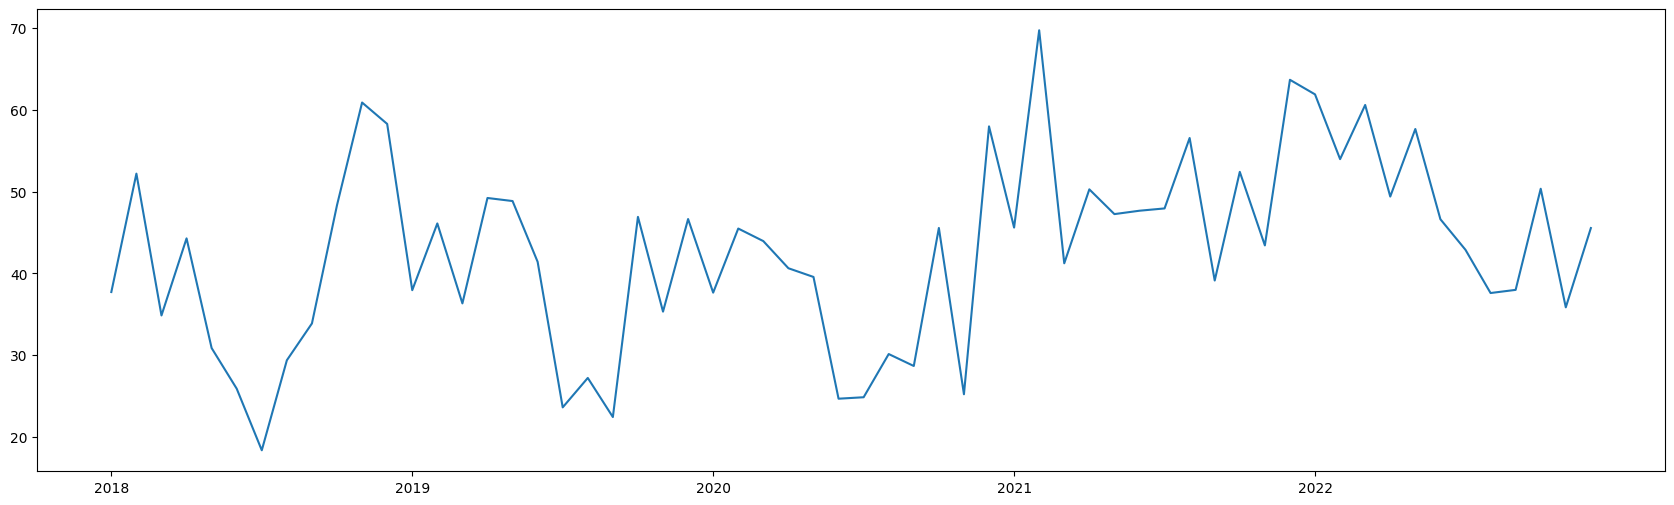

In [152]:
tcc_means = groupby_month_hrrr(hrrr_df, "tcc")

42095


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2066573164.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


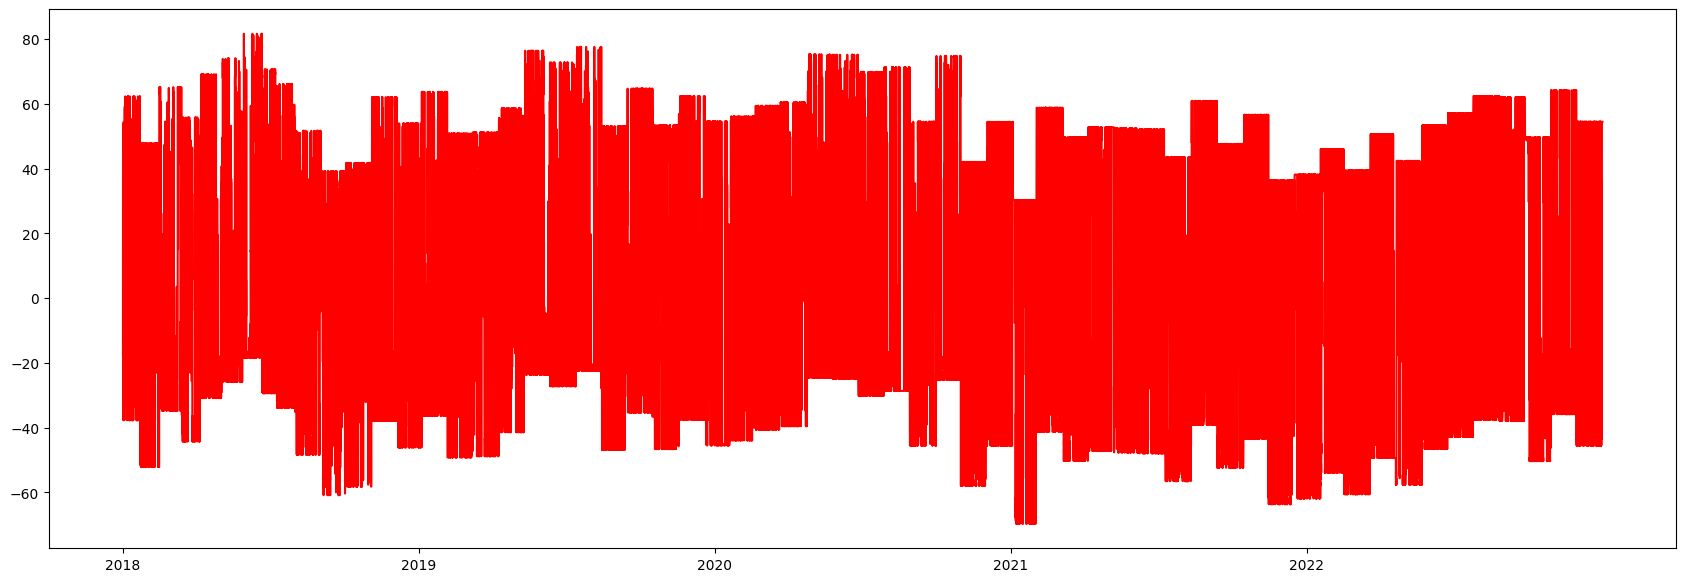

In [153]:
anoms_detection_hrrr(hrrr_df, tcc_means, "tcc")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


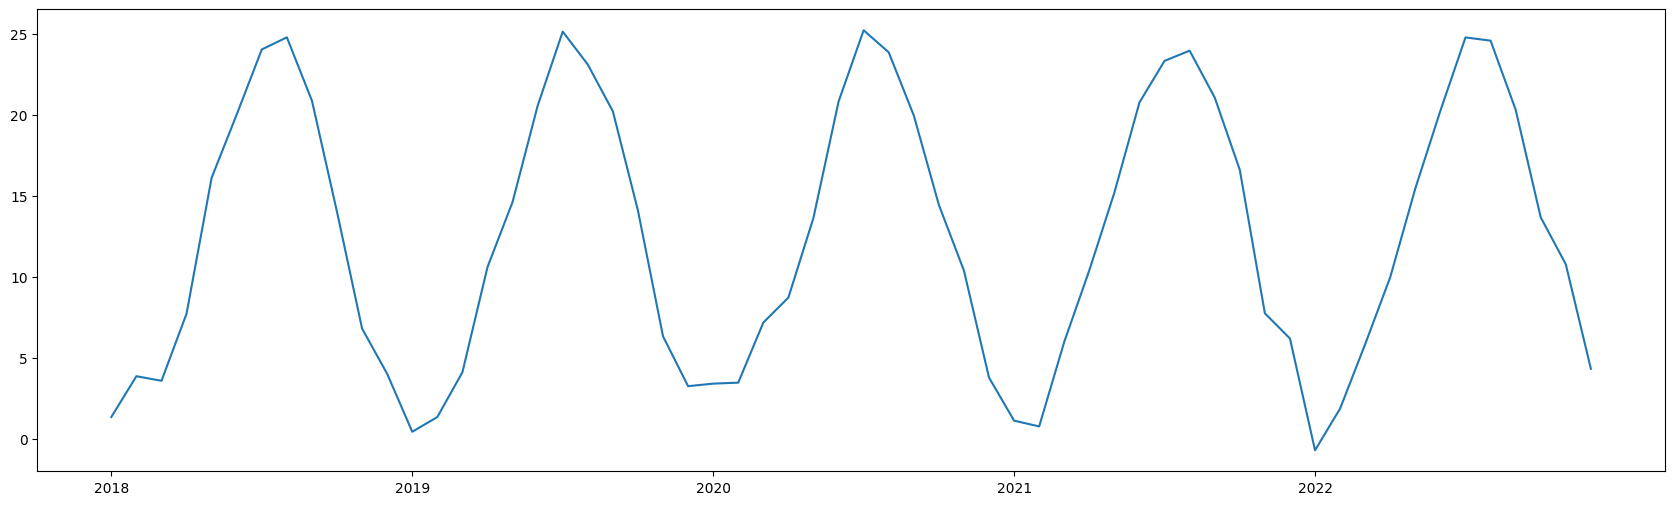

In [154]:
t2m_means = groupby_month(nysm_df, "tair")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


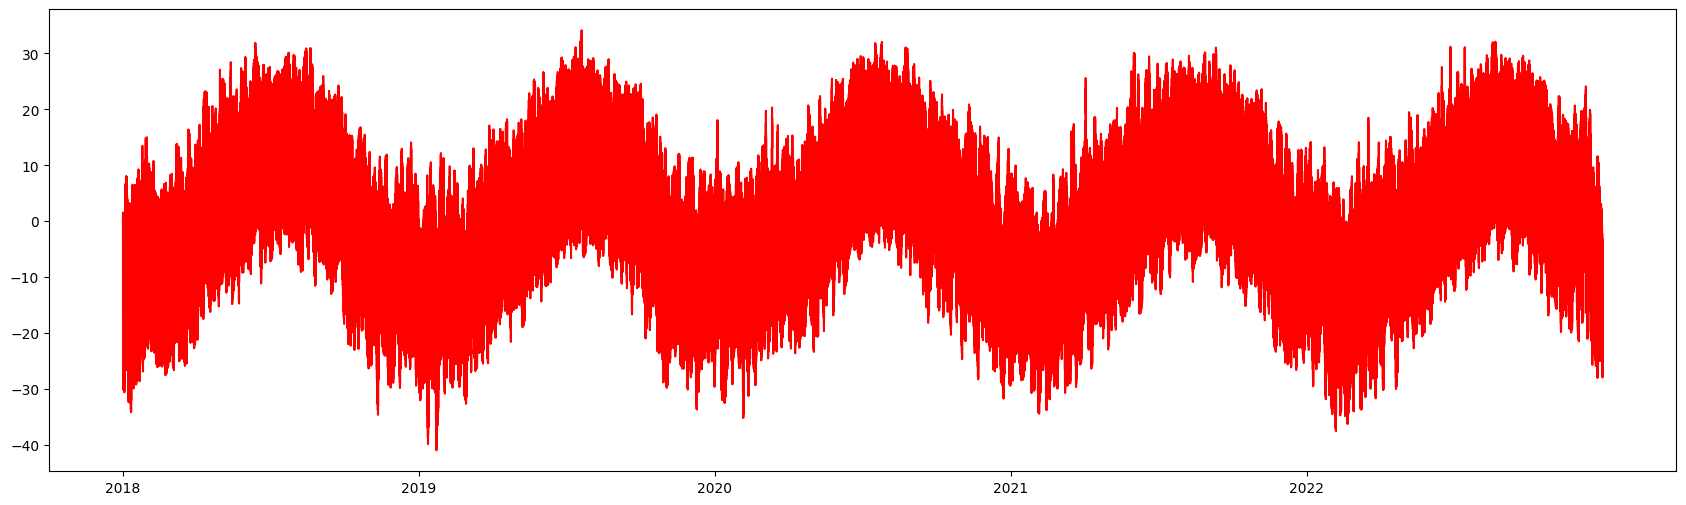

In [156]:
anoms = anoms_detection(nysm_df, t2m_means, "tair")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


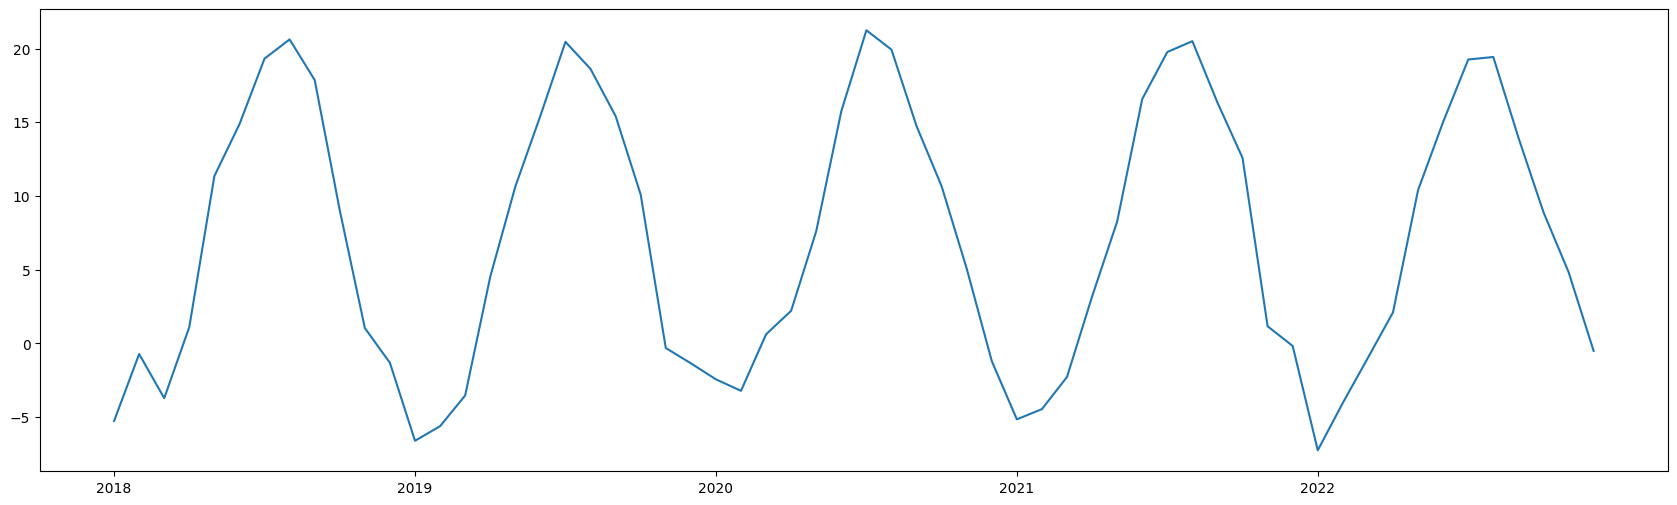

In [157]:
td_means = groupby_month(nysm_df, "td")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


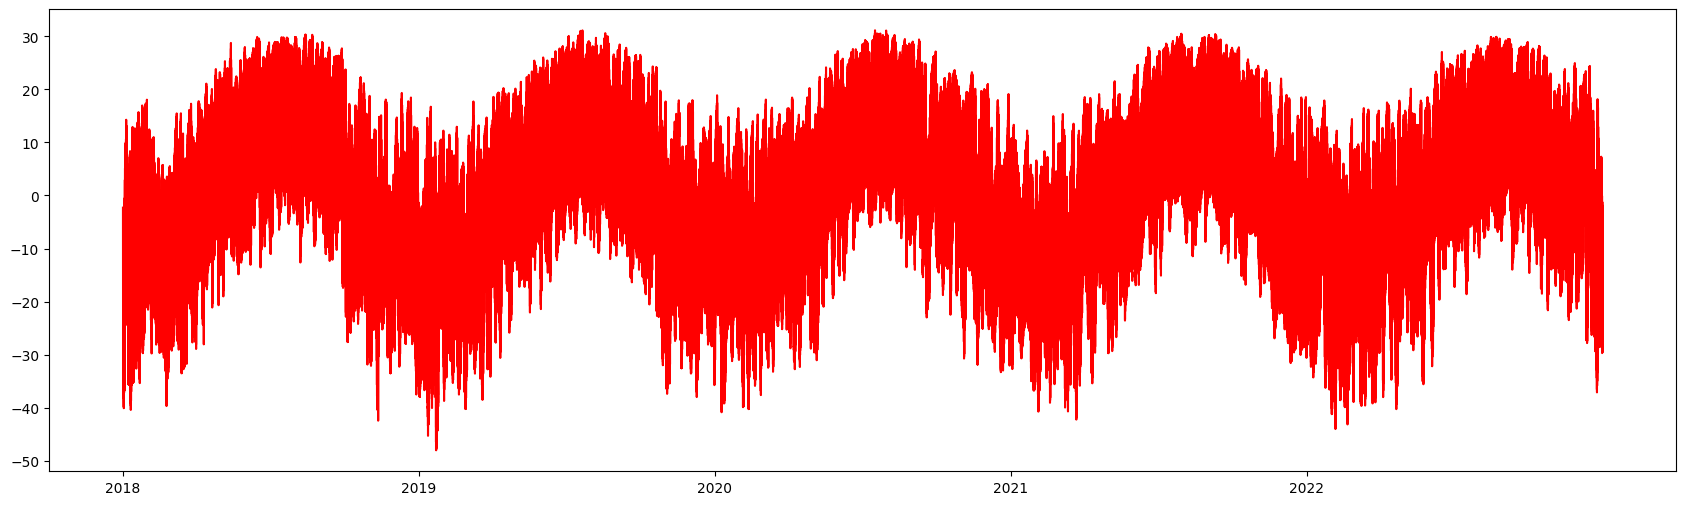

In [158]:
anoms_td = anoms_detection(nysm_df, td_means, "td")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


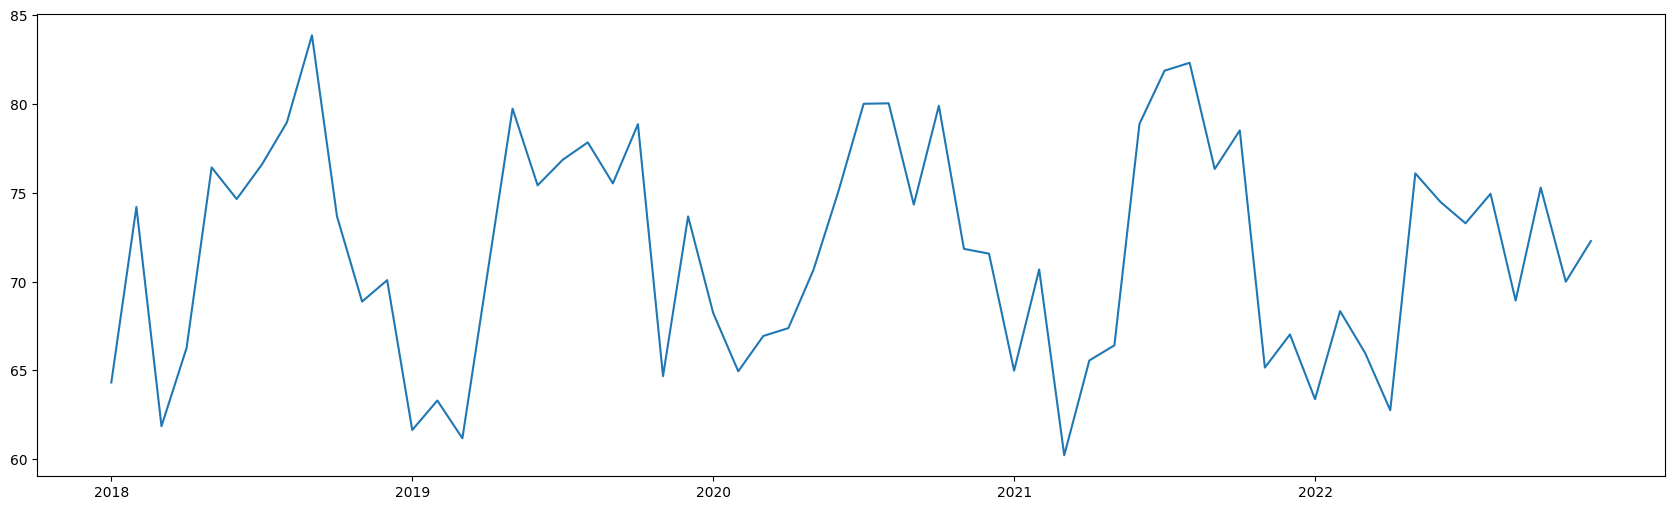

In [159]:
relh_means = groupby_month(nysm_df, "relh")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


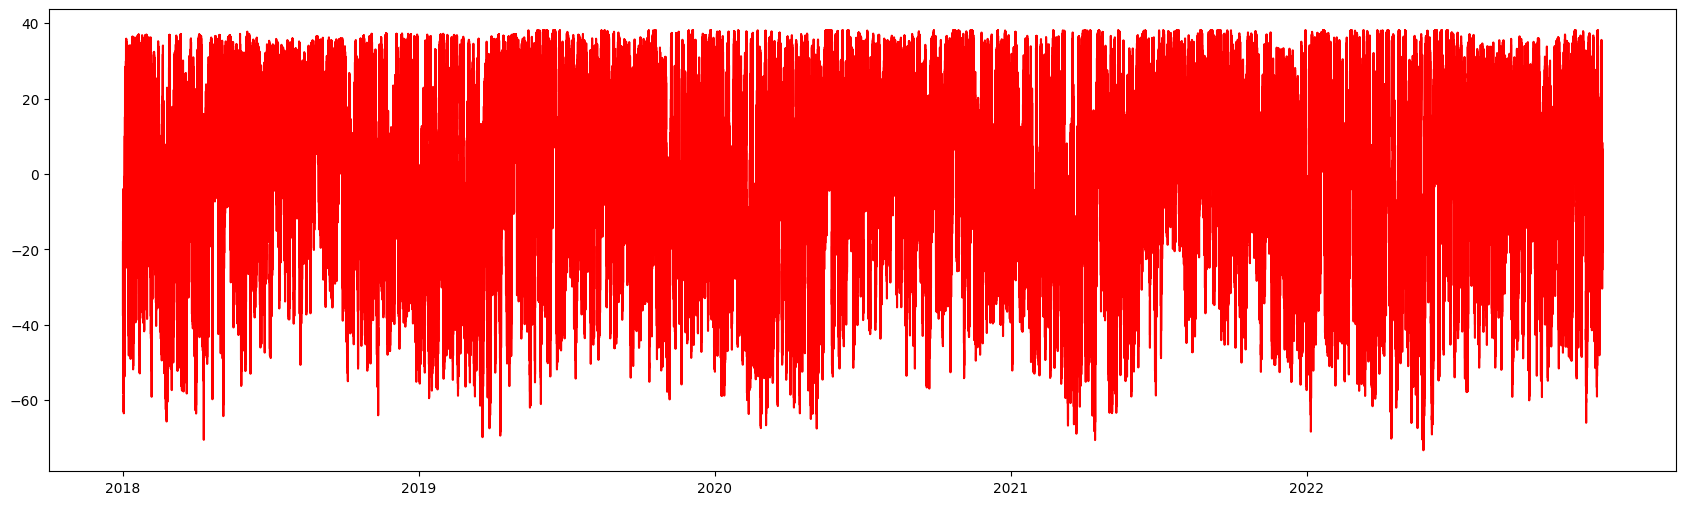

In [160]:
anoms_detection(nysm_df, relh_means, "relh")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


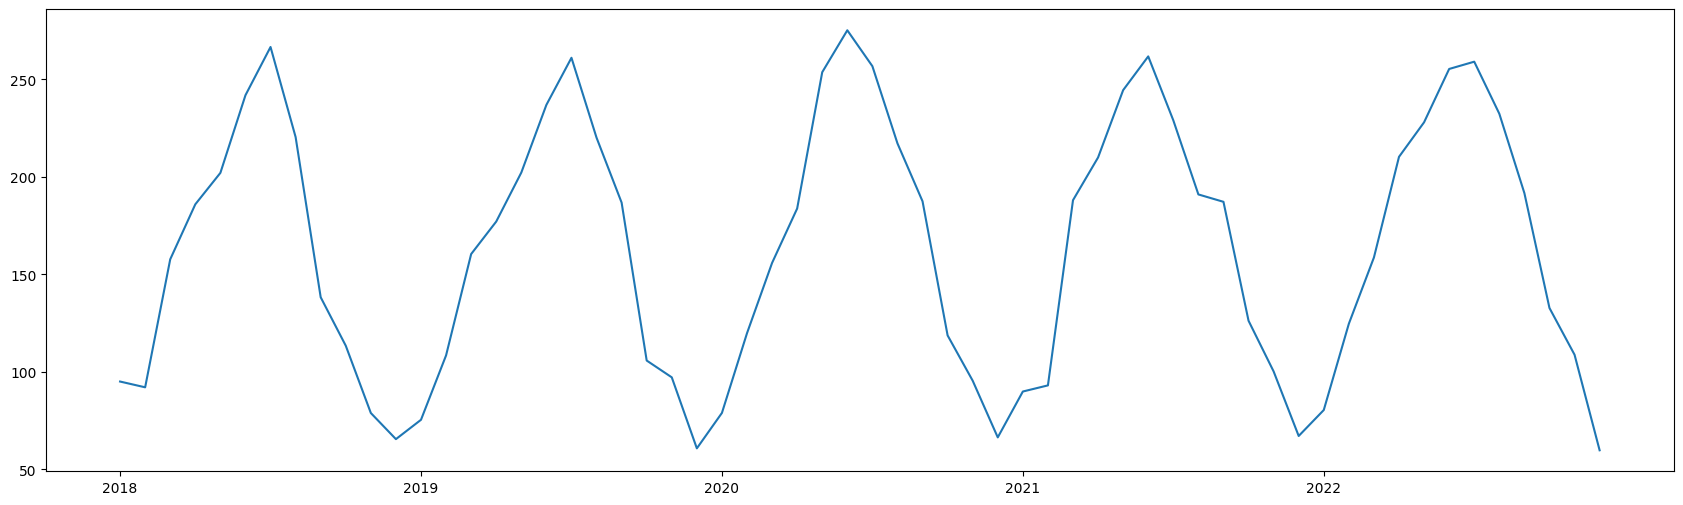

In [161]:
srad_means = groupby_month(nysm_df, "srad")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


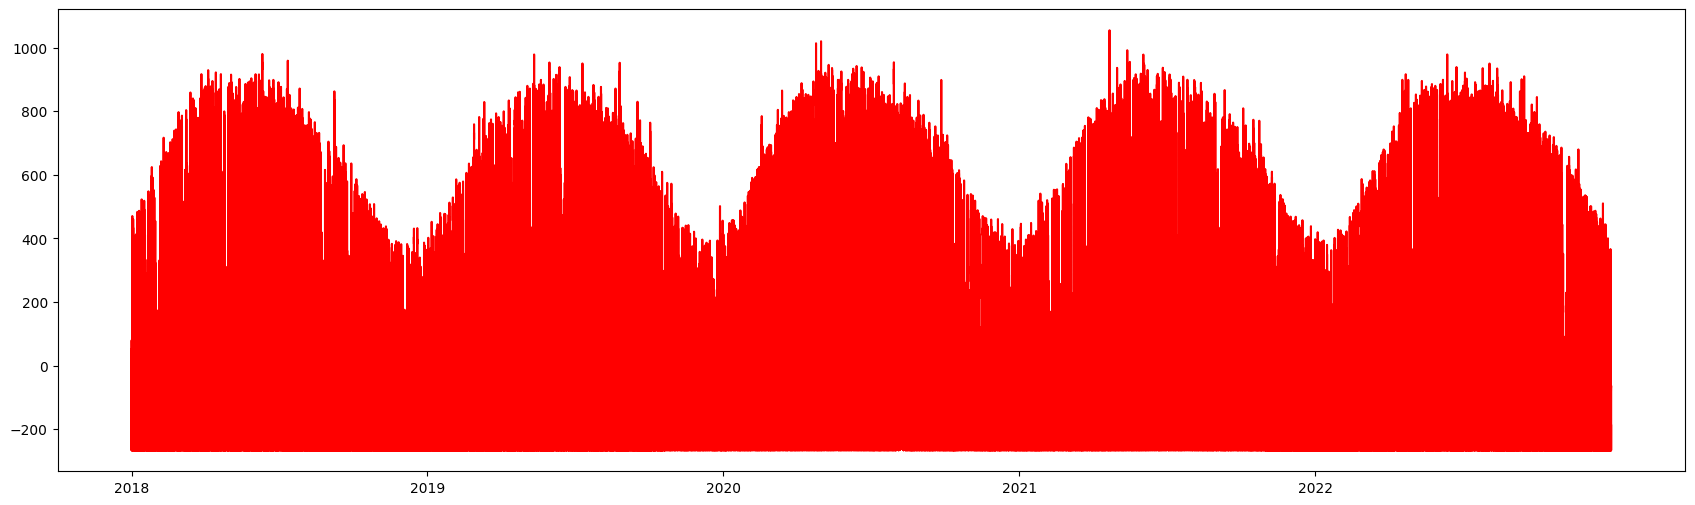

In [162]:
anoms_detection(nysm_df, srad_means, "srad")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


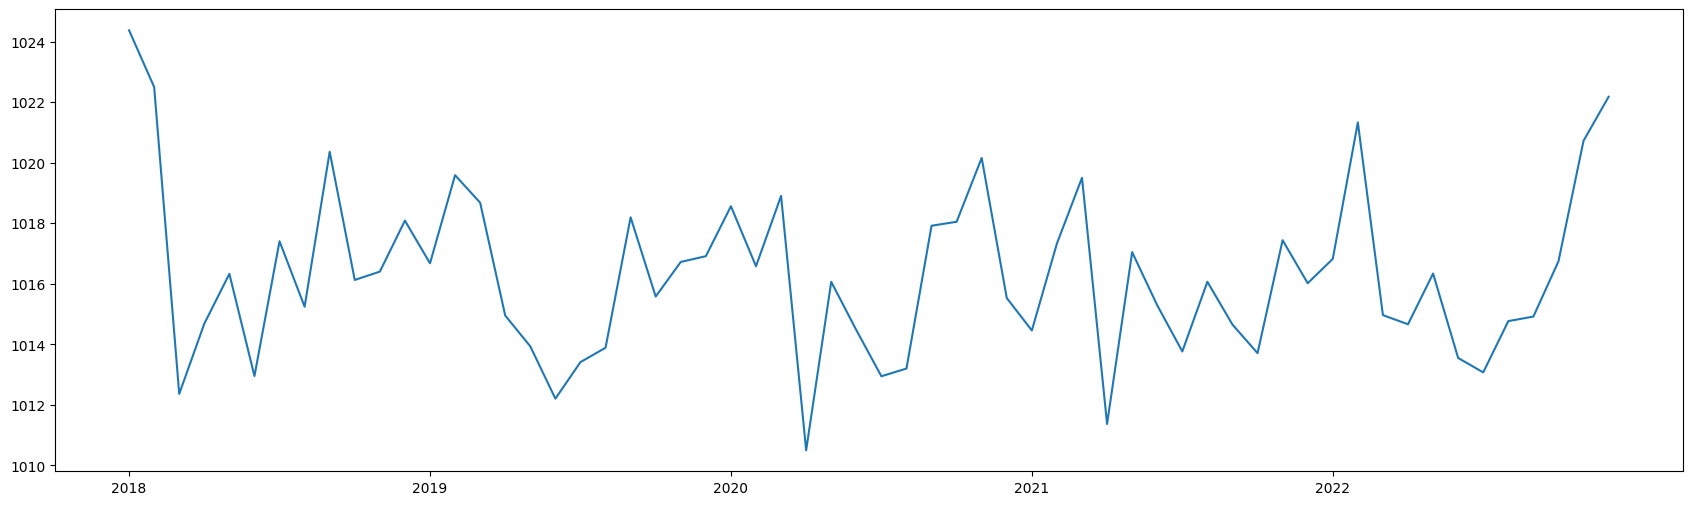

In [163]:
pres_means = groupby_month(nysm_df, "pres")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


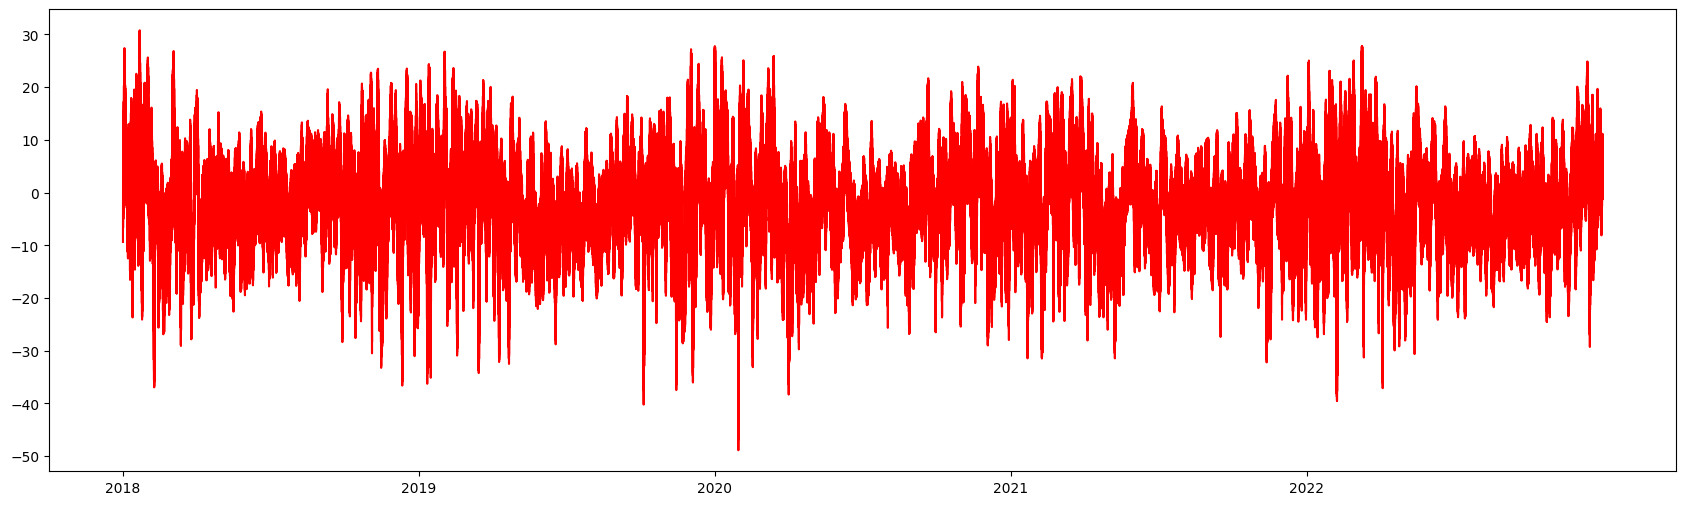

In [164]:
anoms_detection(nysm_df, pres_means, "pres")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


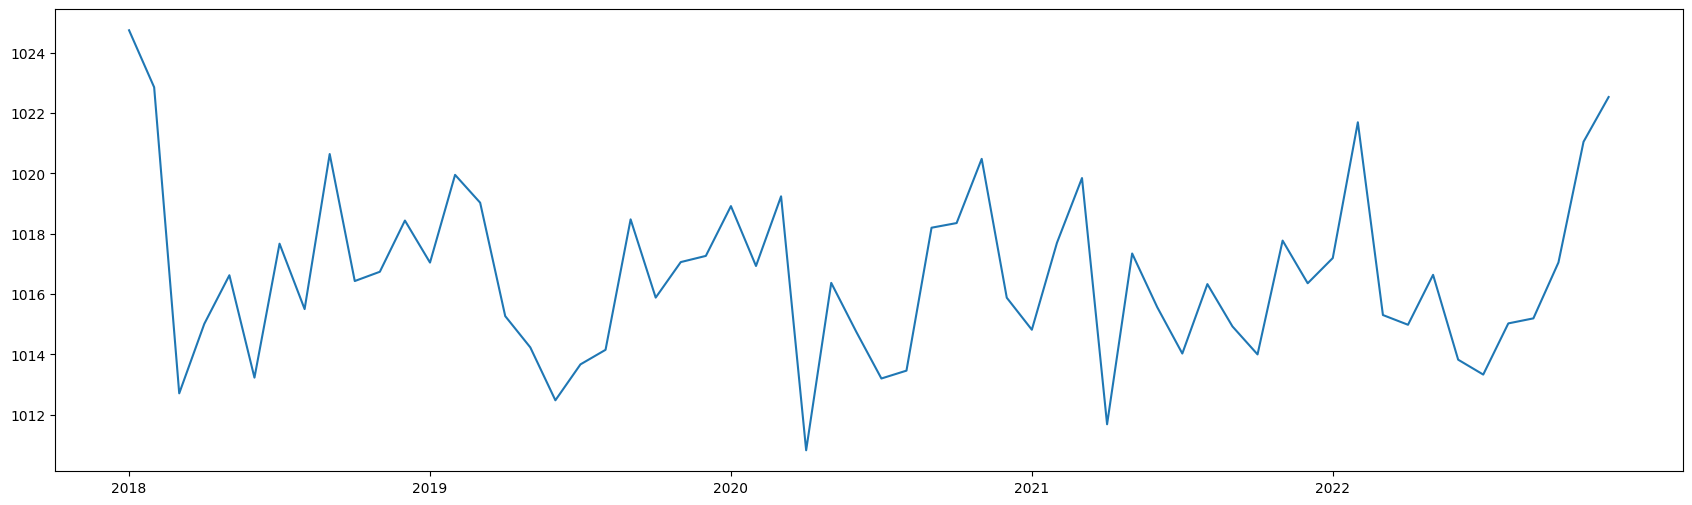

In [165]:
mslp_means = groupby_month(nysm_df, "mslp")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


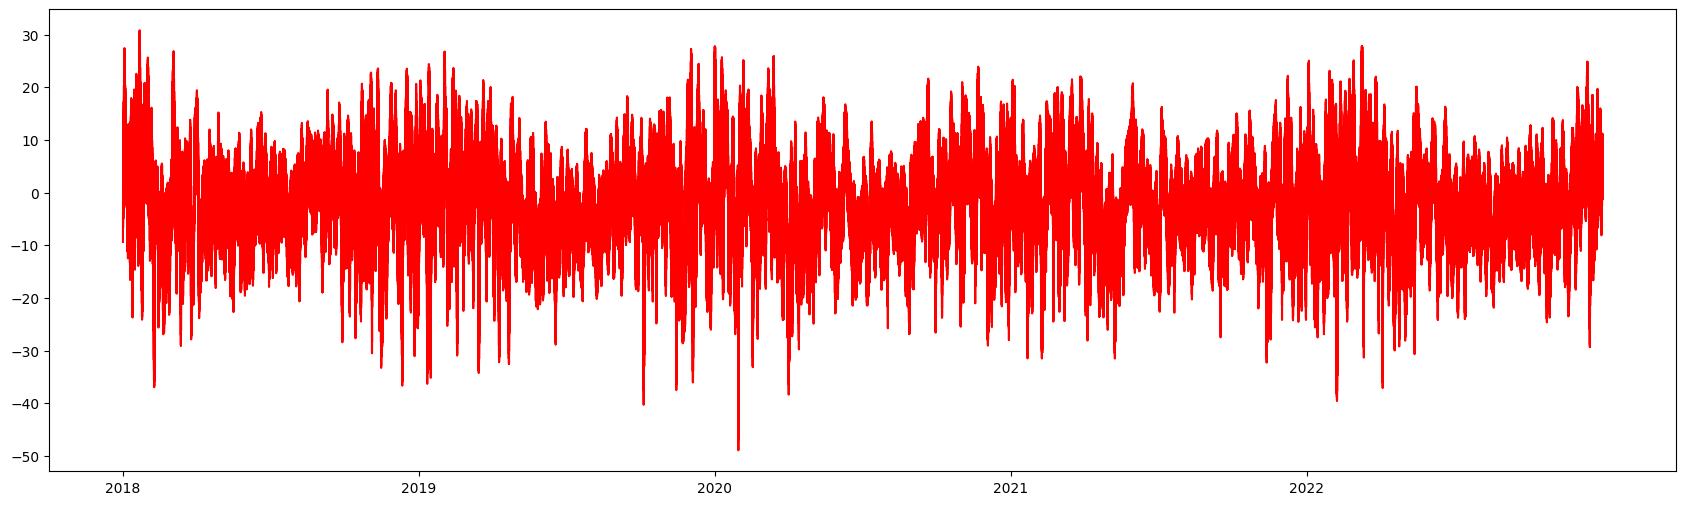

In [166]:
anoms_detection(nysm_df, mslp_means, "mslp")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


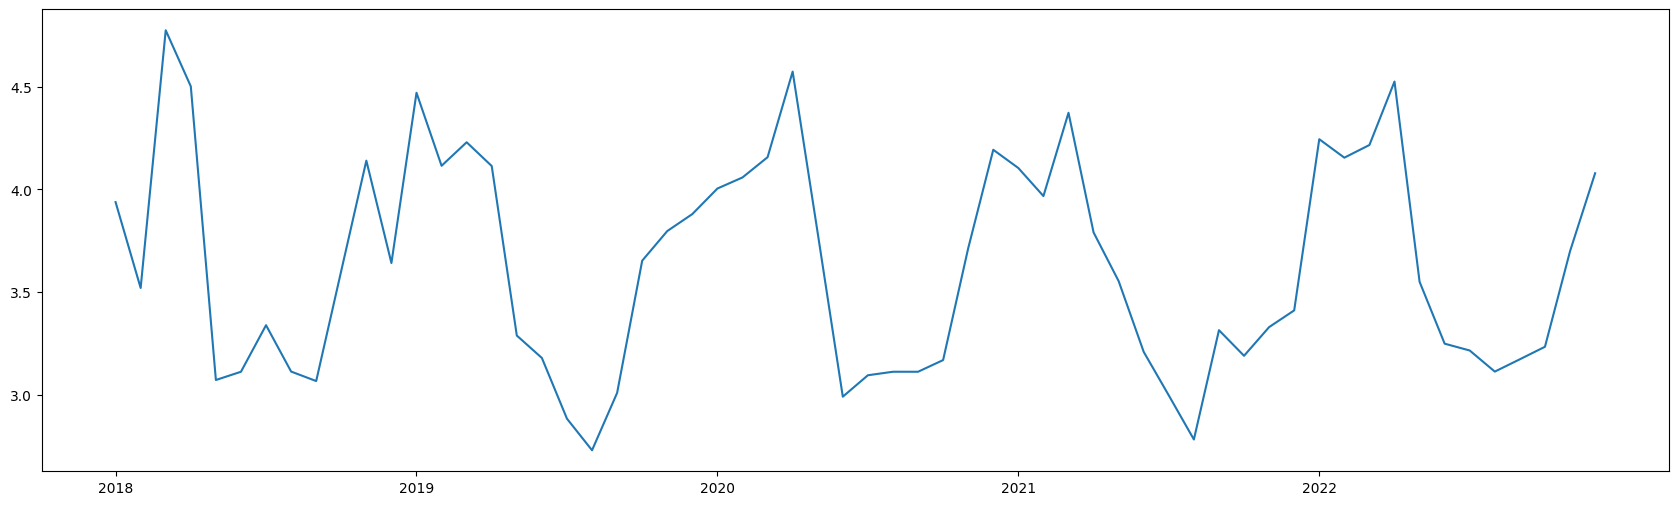

In [167]:
wspd_means = groupby_month(nysm_df, "wspd_sonic")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


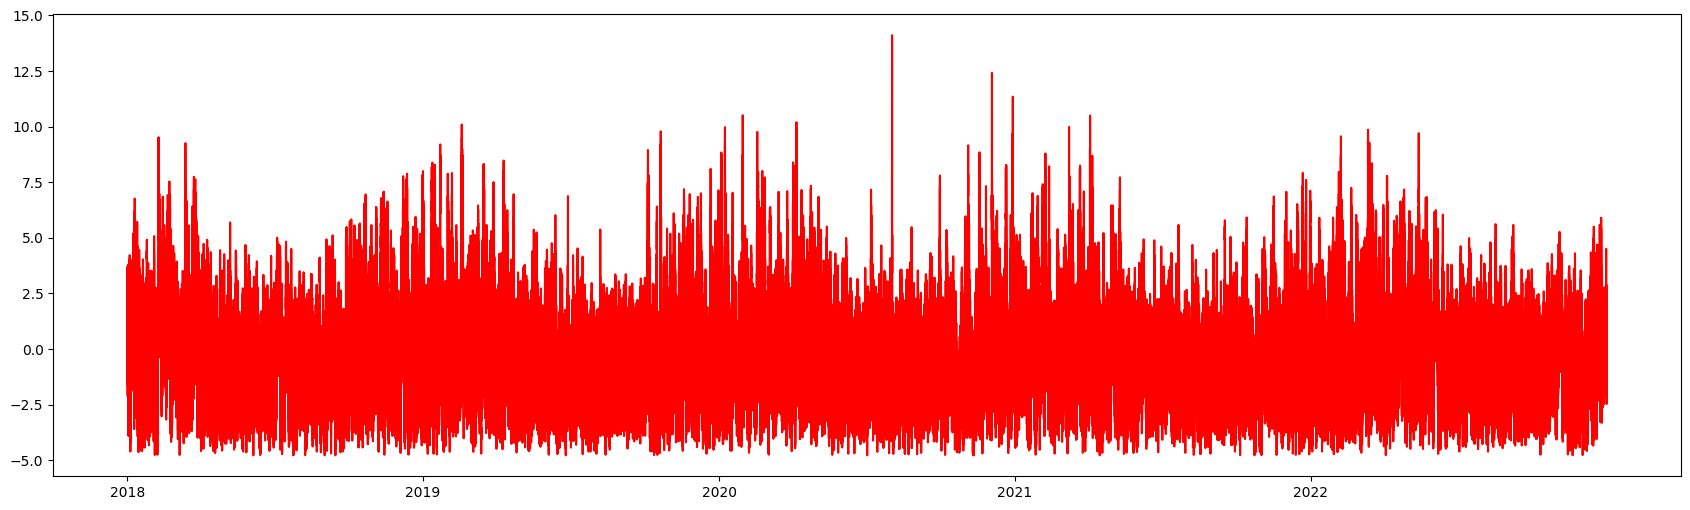

In [168]:
anoms_detection(nysm_df, wspd_means, "wspd_sonic")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


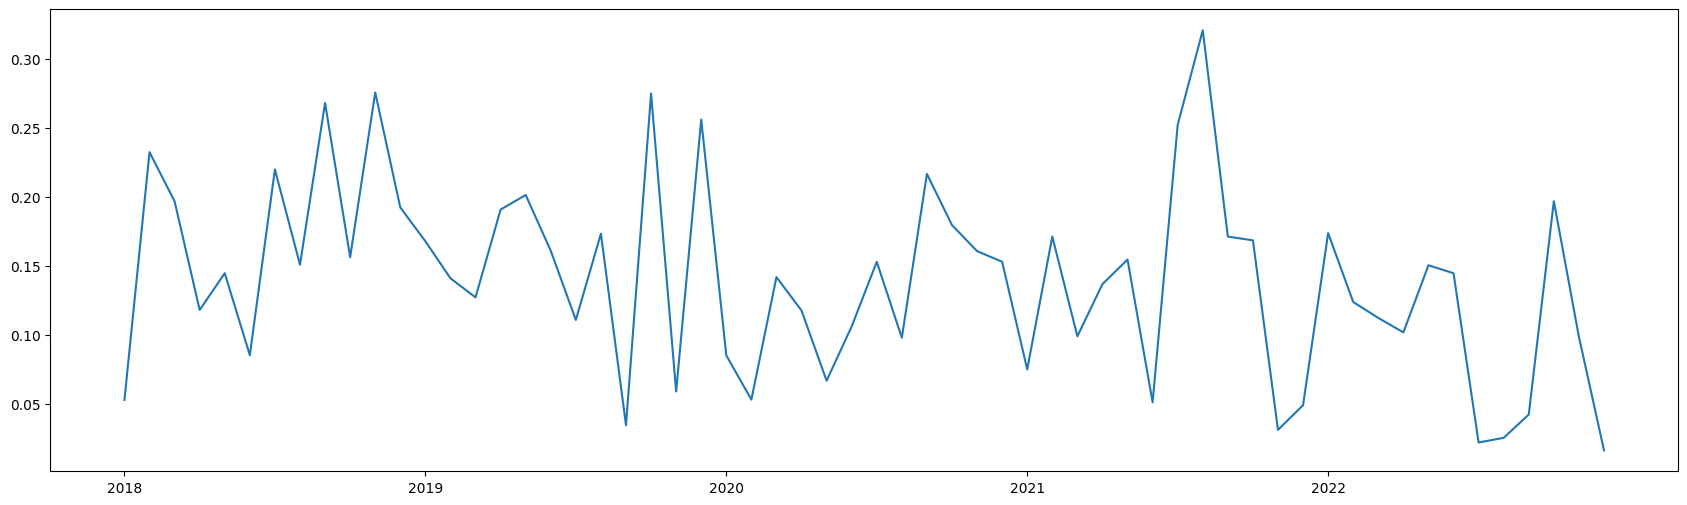

In [169]:
precip_means = groupby_month(nysm_df, "precip_total")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


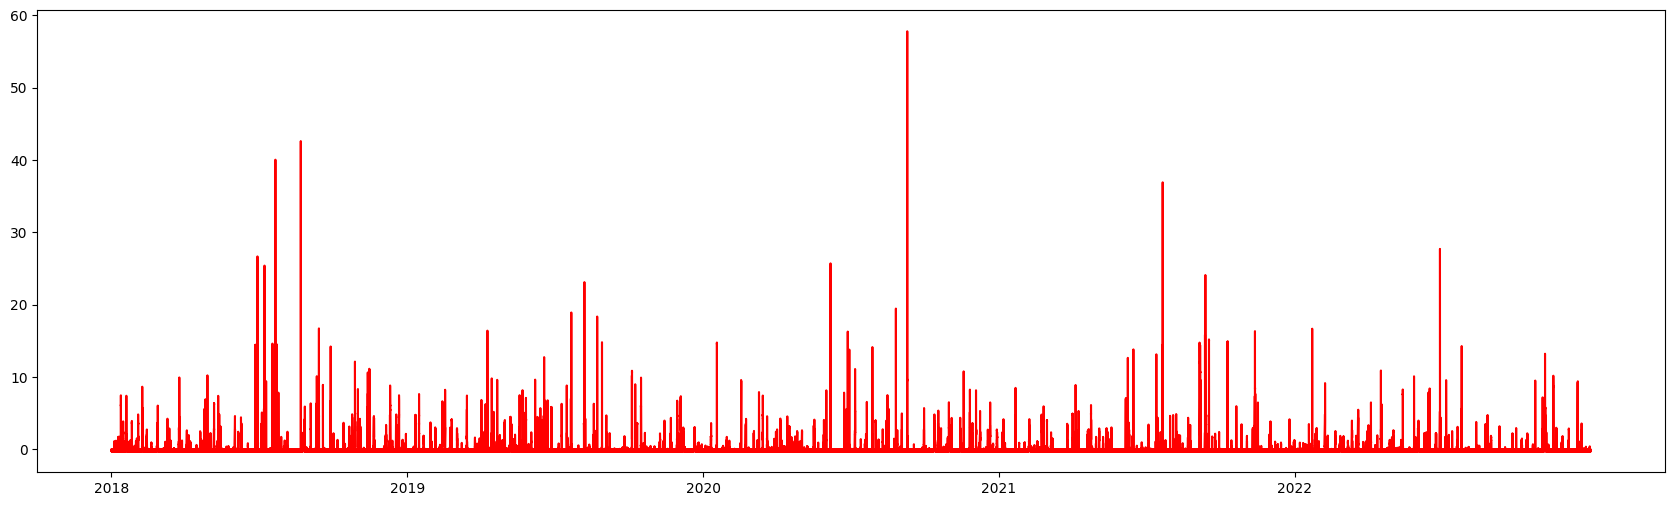

In [170]:
anoms_detection(nysm_df, precip_means, "precip_total")

/tmp/tmp.J431iFr3K3/ipykernel_1134374/3865626854.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


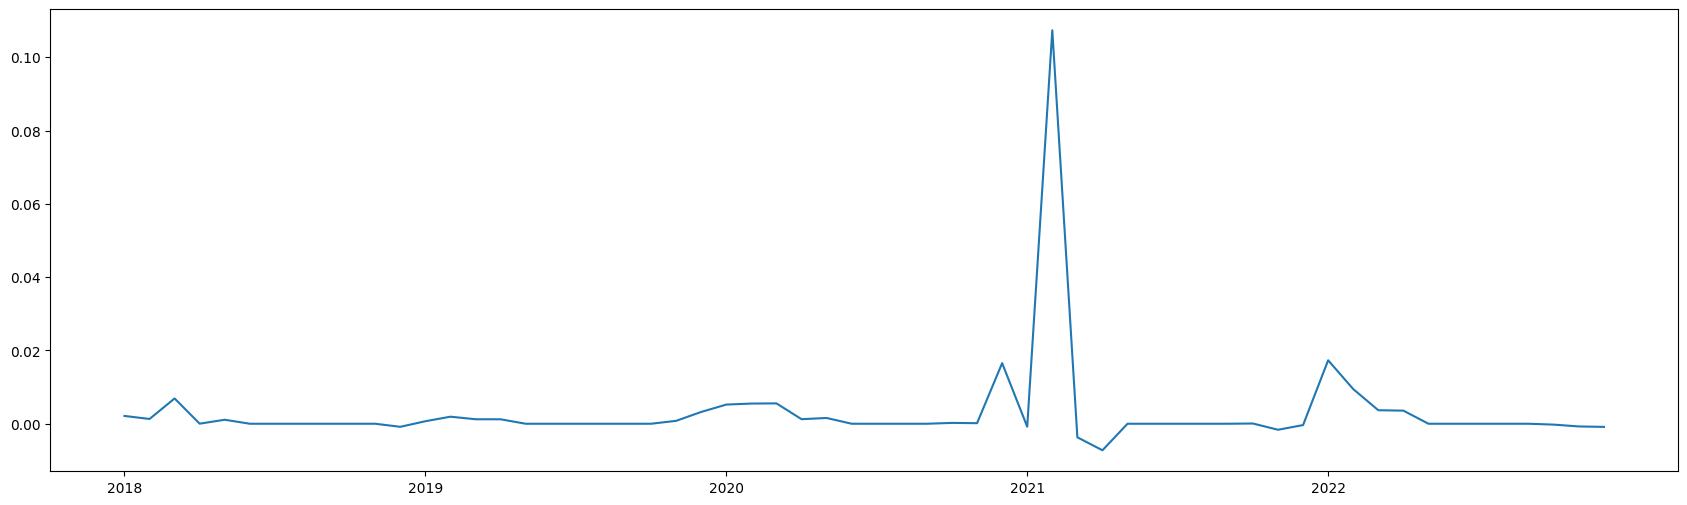

In [171]:
snow_means = groupby_month(nysm_df, "snow_depth")

502704


/tmp/tmp.J431iFr3K3/ipykernel_1134374/2063675389.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


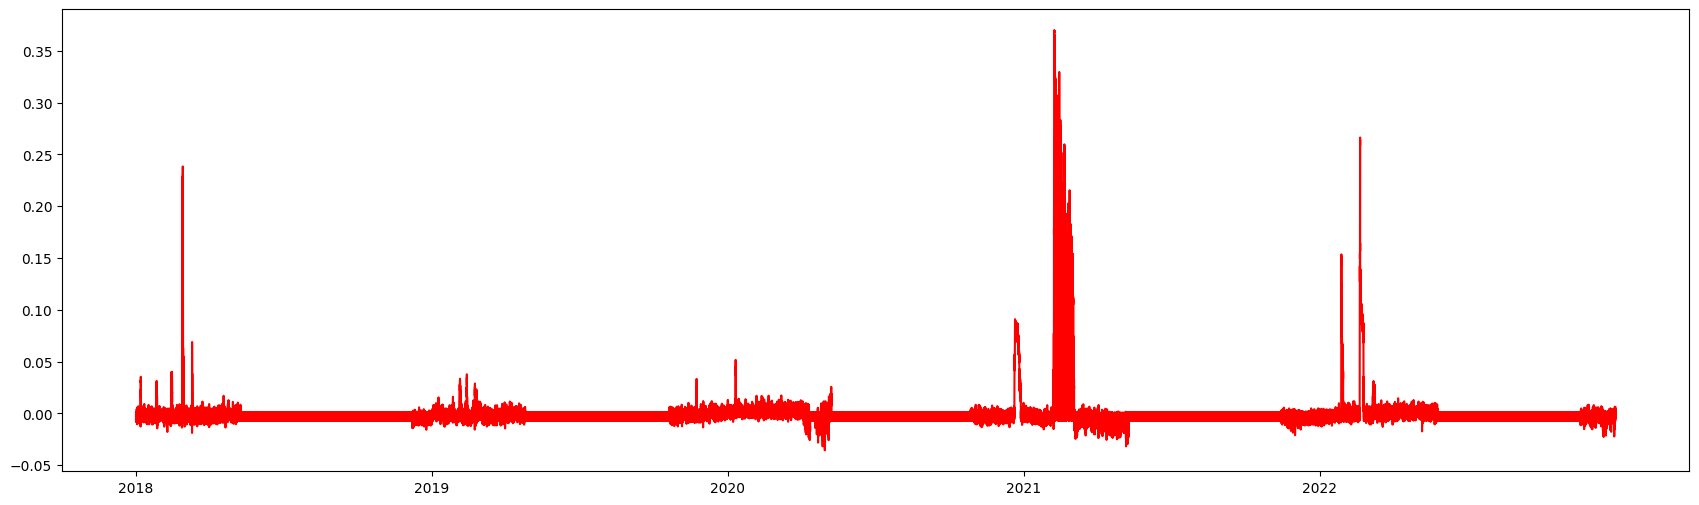

In [172]:
anoms_detection(nysm_df, snow_means, "snow_depth")

In [173]:
# now we can estimate the IMFs for the signal
x = nysm_df["tair"]
imf = emd.sift.sift(x)
print(imf.shape)

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


(41892, 10)


and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [174]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, "hilbert")

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [175]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, "log")
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [176]:
# # visualize
# fig = plt.figure(figsize=(25, 3))
# plt.plot(nysm_df["tair"])

In [177]:
# df.iloc[:, 9:11]

Plot the IMFs

<Axes: xlabel='Time (samples)'>

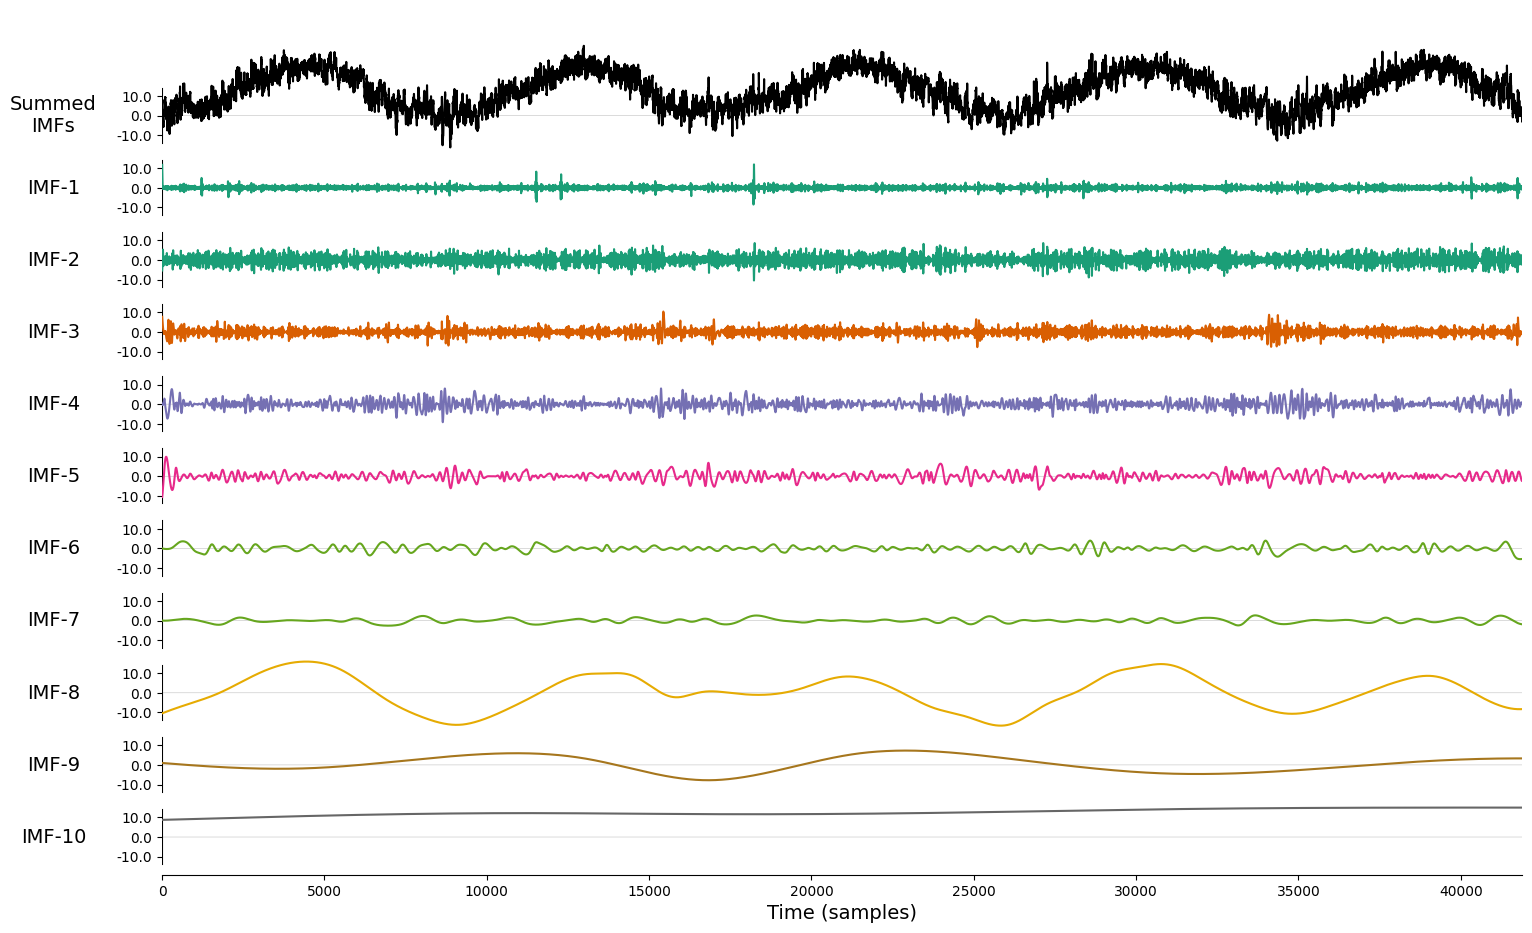

In [178]:
emd.plotting.plot_imfs(imf)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

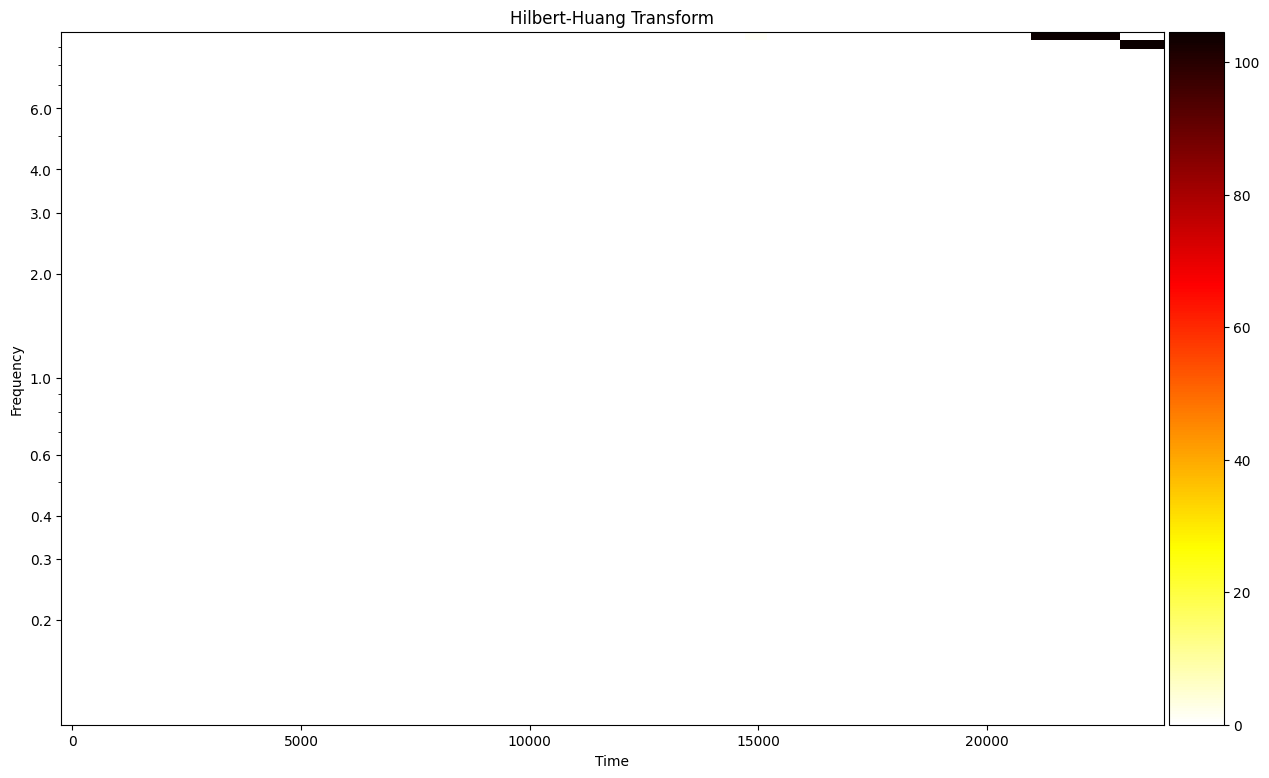

In [179]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)

# ensemble sifting 

In [180]:
x = nysm_df["wspd_sonic"]
imf_opts = {"sd_thresh": 0.05}

<Axes: xlabel='Time (samples)'>

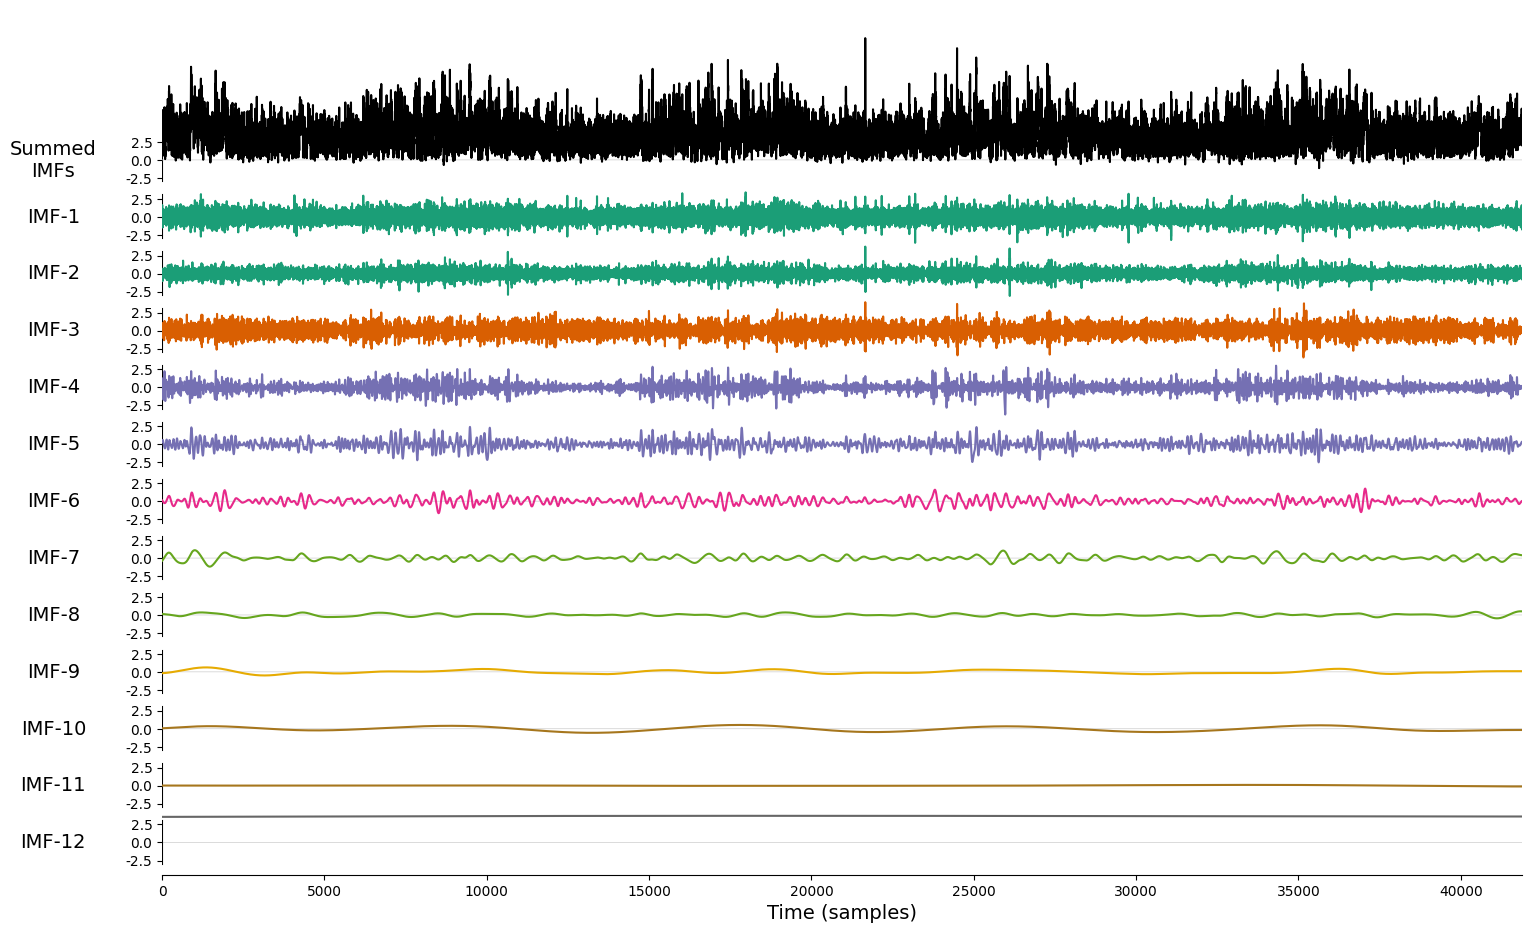

In [181]:
imf = emd.sift.ensemble_sift(
    x, nensembles=42, nprocesses=12, ensemble_noise=1, imf_opts=imf_opts
)
emd.plotting.plot_imfs(imf)

In [182]:
imf.shape

(41892, 12)

and now the Hilbert-Huang transform of this decomposition

In [183]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate - 0.5)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

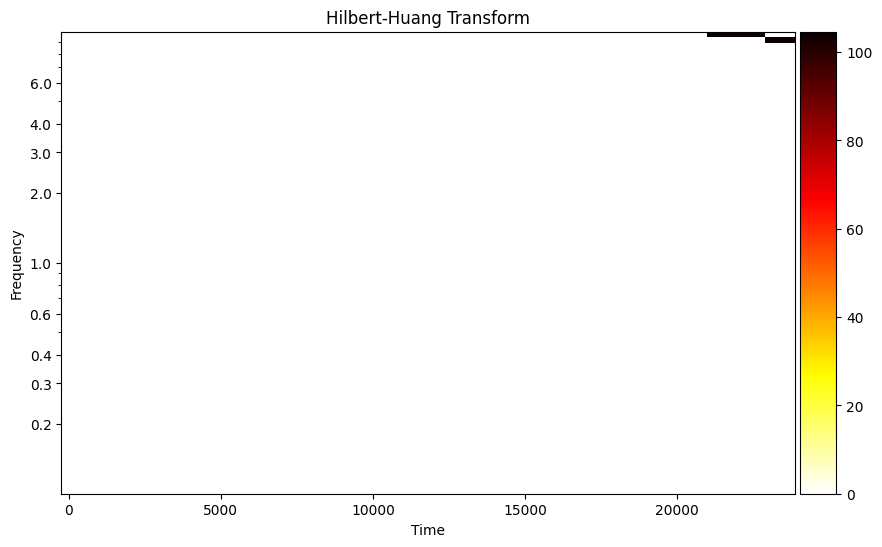

In [184]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)